# Introduction
In today's age of information, we are constantly bombarded with advertisements and news headlines of various kinds on virtually every web page we visit. With so many people connected to the internet, websites and news outlets are in continuous competition for viewers, and so they are pushed to produce ever more interesting, catchy, and provacative article headlines, regardless of their veracity. In recent years, this has led to an influx of "news" headlines that are designed essentially entirely to capture the attention of new viewers, rather than to convey any real, practical journalistic information. These catchy headlines and their associated content are referred to as "clickbait". Sites like BuzzFeed and Upworthy are well known for hosting many of these kinds of articles.

In a formal sense, clickbait is somewhat hard to define. The Oxford English dictionary defines it as *"on the internet, content whose main purpose is to attract attention and encourage visitors to click on a link to a particular web page"*. In a general sense, clickbait headlines are those which satisfy two main criteria:

1. They exploit the so-called "curiosity gap" by not explaining the full article contents
2. They provide misleading information about the article contents

In other words, these headlines contain text which leaves the reader curious about what the article contents might be, or they contain text about topics not really covered in the article itself. Examples of clickbait headline include things like

* I left my husband and daughter home alone, and you'll never believe what happened!
* 19 Tweets anyone addicted to diet coke will totally relate to
* What these pilots do with dogs is the most brilliant thing I've ever seen
* She picks this object off the ground, but watch what happens when it starts to move!

We must be sure to make a distinction here between clickbait and fake news, which has also been talked about more and more as of late. The distinction comes from the fact that fake news actively tries to get the reader to believe things that are untrue. Clickbait, on the other hand, usually just contains "junk" news with no real journalistic integrity, and is not constructed to get the reader to believe false claims. 

Since clickbait is becomming increasingly common, and is generally considered a nuisance to internet users, let's see if we can use machine learning and natural language processing to identify these headlines automatically. This sort of study has been carried out before by, for example, [Chakraborty et al.](http://cse.iitkgp.ac.in/~abhijnan/papers/chakraborty_clickbait_asonam16.pdf), and is covered in [this informative article](https://www.linkedin.com/pulse/identifying-clickbaits-using-machine-learning-abhishek-thakur).

# Data Collection
The dataset used in the Chakraborty et al. study is publicly available, and can be found [here](https://github.com/bhargaviparanjape/clickbait/tree/master/dataset). Despite the fact that this data source is so readily available, it would be more interesting to try and obtain a dataset ourselves in a different way. To carry out this project, we'll need to collect a large number of both clickbait and non-clickbait (i.e., legitimate news article) headlines. A really great place to look for these data is the website Reddit. Reddit is a content aggregator site composed thousands of differnt forums (called subreddits) where one can discuss nearly any topic of interest - topics like science, art, and video games, just to name a few. Luckily for us, Reddit also has subreddits where users post news articles pertaining to world news, environment, economics, and business. This is a perfect source for collecting non-clickbait headlines. Reddit also happens to have a fun subreddit called "savedyouaclick", where users post particularly misleading clickbait headlines they've found online, as well as their reasoning for declaring them as such. A screenshot of the savedyouaclick subreddit is shown below.

![chronjob](https://github.com/degravek/notebooks/blob/master/images/savedyouaclick.png?raw=true)

For example, one of the submitted headlines above reads "Is Connor McGregor Hinting at a Possble Fight with Muhammad Ali? | No, Muhammad Ali is dead". The first part before the "|" regarding Connor McGregor is the actual clickbait headline, and the second part is the rational for why the article was labeled as such $-$ Muhammad Ali is no longer alive. This subreddit is an amazing source of data because all headlines are already hand-labeled as clickbait by the users that post there. This saves us countless hours of tracking down headlines and labeling them ourselves.

In order to scrape these subreddits, we could use a package like BeautifulSoup to parse the HTML and grab the appropriate article headlines. However, Reddit tends to post only 25 submissions per page before a "next" button must be clicked to advance to the next page. Having to call BeautifulSoup on every single page manually would take a really long time, and would be very tedious. However, there is a really useful alternative tool available called Selenium that will allow us to parse each page quickly *and* will automatically click the "next" button for us to advance to all available subsequent pages.

I found a simple implementation of Selenium online, and was able to modify it to scrape the data we need for this project. The code is shown below. For any particular subreddit, this implementation will search all of the "hot", "rising", "gilded", and "top" entries.

In [ ]:
from selenium.common.exceptions import StaleElementReferenceException
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.keys import Keys
from selenium import webdriver
from time import sleep
import json
import datetime

delay = 1  # Time to wait on each page load before reading the page
driver = webdriver.Safari()  # Options are Chrome() Firefox() Safari()

odir = '/Users/degravek/Downloads/'
filename = 'reddit_news'
selector = 'title may-blank '

type = ['hot', 'rising', 'gilded', 'top/?sort=top&t=all',
        'top/?sort=top&t=year', 'top/?sort=top&t=month', 'top/?sort=top&t=week']

data = []
for reddit in type:
    url = "https://www.reddit.com/r/savedyouaclick/" + reddit
    print(url)

    for count in range(0,10000,25):
        driver.get(url)
        sleep(delay)
        try:
            content = driver.find_elements_by_class_name(selector)
            print('{} count, {} posts found'.format(count, len(content)))

            for element in content:
                if "|" in element.text:
                    try:
                        element = element.text.split('|')[0].strip()
                        data.append(element.text)
                    except StaleElementReferenceException as e:
                        print('lost element reference', element)

        except NoSuchElementException:
            print('no posts on this page')
        try:
            div = driver.find_element_by_class_name('next-button')
            url = div.find_element_by_css_selector('a').get_attribute('href')
        except:
            break

driver.close()

df = pd.DataFrame(data)
df.drop_duplicates(inplace=True)
df.to_csv(odir + filename + '.csv', mode='w', encoding='utf-8', index=False, header=False)

After scraping the savedyouaclick, world news, environment, economics, and business subreddits, I was left with 5,637 clickbait and 6,080 non-clickbait headlines. Let's read these data in and get to work!

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from string import punctuation
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import re

import matplotlib.pyplot as mp
%matplotlib inline

idir = '/Users/degravek/DataScience/Site/clickbait/reddit/'
df_y = pd.read_table(idir + 'y_clickbait.txt', encoding='utf-8', names=['text'])
df_n = pd.read_table(idir + 'n_clickbait.txt', encoding='utf-8', names=['text'])

df_y['clickbait'] = 1
df_n['clickbait'] = 0

df = df_y.append(df_n, ignore_index=True).reset_index(drop=True)

Let's quickly take a look at the number of clickbait (1) and non-clickbait (0) headlines in our dataset.

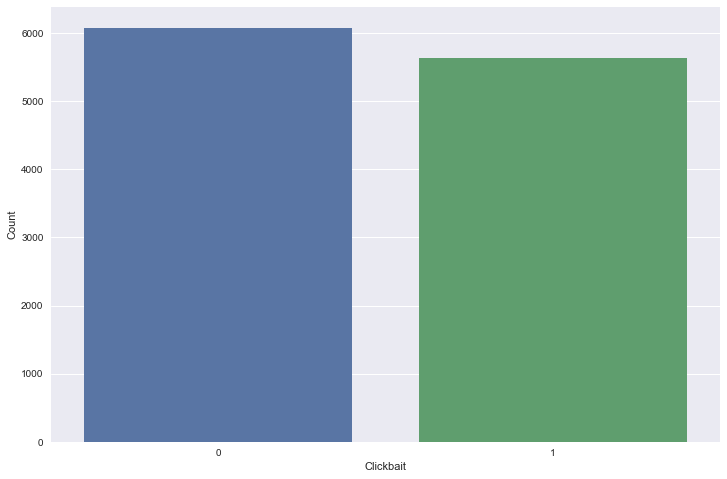

In [116]:
figure, axes = mp.subplots(nrows=1, ncols=1, figsize=(12,8))

sns.countplot(df['clickbait'])
mp.xlabel('Clickbait')
mp.ylabel('Count')

# Feature Engineering
Now that the data is loaded, one option is to move ahead using only the headline text to identify clickbait. It turns out that this actually gives very good results. However, it is also possible to engineer some new features from the available data. These new features include things like:

* Number of words in the headline
* Number of stop words in the headline
* Number of contractions in the headline
* Frequency of various parts of speech in the headline
* Is the headline a question?
* Ratio of stop words to total number of words
* Ratio of contractions to total number of words

To produce these new features, we'll first need to define a few functions. The function processText carries out the task of processing the raw headlines. It makes every headline lowercase, and removes any punctuation and extra white space. Next, the function numStopWords tokenizes (splits) each headline into it's individual words, and counts the number of those words that appear in the NLTK corpus of pre-defined stopwords.

It is often the case that clickbait headlines are stated in the form of a question. For example, something like "Can you spot the amazing thing in this photo?". To this end, function isQuestions detects whether or not the last character in the headline is a question mark. These headlines also tend to contain more informal writing than non-clickbait headlines. As such, they may contain many more contractions or occurrences of slang. Below, we make a list of possible contractions to look for, as well as a function, numContract to check for them.

Lastly, a function is defined to check the part-of-speech (i.e., noun, verb, adjective, etc.) of each word in a headline. It's possible that non-clickbait headlines contain, for example, more nouns than do clickbait headlines. This part-of-speech tagging is carried out using methods from the NLTK package.

In [47]:
contractions = ["aren't", "can't", "couldn't", "didn't", "doesn't", "don't", "hadn't",
                "hasn't", "haven't", "he'd", "he'll", "he's", "I'd", "I'll", "I'm", "I've",
                "isn't", "let's", "mightn't", "mustn't", "shan't", "she'd", "she'll", "she's",
                "shouldn't", "that's", "there's", "they'd", "they'll", "they're", "they've",
                "we'd", "we're", "we've", "weren't", "what'll", "what're", "what's", "what've",
                "where's", "who's", "who'll", "who're", "who's", "who've", "won't", "wouldn't",
                "you'd", "you'll", "you're", "you've"]

punctuation = '!"#?$%“”&\'()’*+,—./:;<=>@[\\]^_`{|}~…' #(removed - symbol)
def processText(text):
    result = text.lower()
    result = ''.join(p for p in result
                    if p not in punctuation)
    result = re.sub(r' +', " ", result).strip()
    return result

stop = stopwords.words('english')
def numStopWords(text):
    s = text.split()
    num = len([word for word in s if word in stop])
    return num

def numContract(text):
    s = text.lower().split()
    num = len([word for word in s if word in contractions])
    return num

def numPunc(text):
    num_exc = len([p for p in text if p == "!"])
    num_que = len([p for p in text if p == "?"])
    return num_exc + num_que

def numNumbers(text):
    result = len([w for w in text.split() if w.isdigit()])
    return result

def isQuestion(text):
    if text[-1] == "?":
        return 1
    else:
        return 0

def partSpeech(text):
    s = text.lower().split()
    nonstop = [word for word in s if word not in stop]
    pos = [part[1] for part in nltk.pos_tag(nonstop)]
    pos = ' '.join(pos)
    return pos

With our functions defined, let's apply them to the data.

In [48]:
df['text_pro'] = df['text'].apply(processText)
df['num_punc'] = df['text'].apply(numPunc)
df['question'] = df['text'].apply(isQuestion)
df['num_contract'] = df['text'].apply(numContract)

df['num_stop'] = df['text_pro'].apply(numStopWords)
df['num_words'] = df['text_pro'].apply(lambda x: len(x.split()))
df['num_numbers'] = df['text_pro'].apply(numNumbers)
df['part_speech'] = df['text_pro'].apply(partSpeech)
df['contract_ratio'] = df['num_contract']/df['num_words']
df['stop_ratio'] = df['num_stop']/df['num_words']

Here's what the data look like.

In [49]:
df.drop('text_pro', axis=1).head()

,text,clickbait,num_punc,question,num_contract,num_stop,num_words,num_numbers,part_speech,contract_ratio,stop_ratio
0,10 Celebs Killin The Elf On The Shelf Game,1,0,0,0,3,9,1,CD JJ NN PRP PRP NN,0.0,0.333333
1,All The Looks At The People's Choice Awards,1,0,0,0,4,8,0,NNS NNS NN NNS,0.0,0.500000
2,Does Kylie Jenner Know How To Wear Coats? A Ve...,1,1,0,0,5,12,0,VB NN VBP IN NNS JJ NN,0.0,0.416667
3,24 GIFs That Show How Corinne Is The Greatest ...,1,0,0,0,4,12,1,CD NNS VBP JJ JJS NN NN RB,0.0,0.333333
4,All The Looks At The 2017 Golden Globes,1,0,0,0,4,8,1,NNS CD JJ NNS,0.0,0.500000


Let's plot some of these columns.

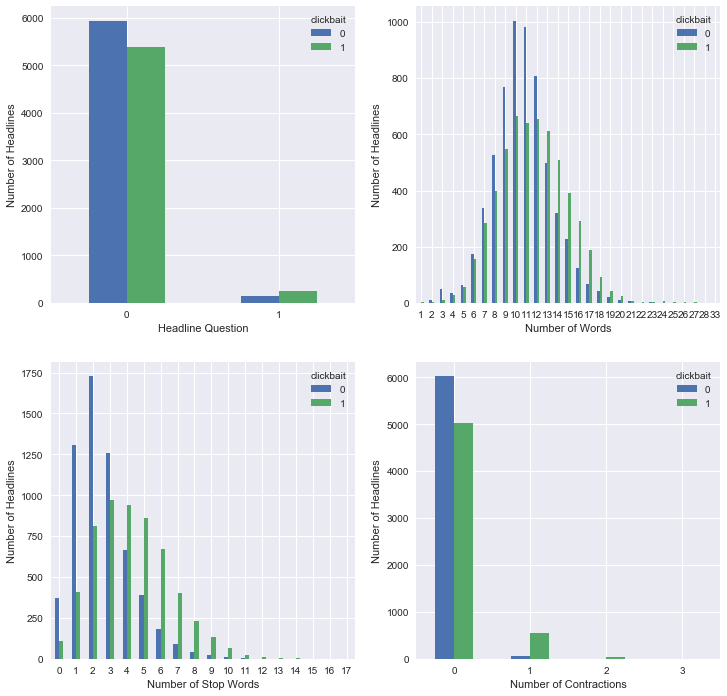

In [50]:
figure, axes = mp.subplots(nrows=2, ncols=2, figsize=(12,12))

plot = df.groupby('question')['clickbait'].value_counts().unstack().plot.bar(ax=axes[0,0], rot=0)
plot.set_xlabel('Headline Question')
plot.set_ylabel('Number of Headlines')

plot = df.groupby('num_words')['clickbait'].value_counts().unstack().plot.bar(ax=axes[0,1], rot=0)
plot.set_xlabel('Number of Words')
plot.set_ylabel('Number of Headlines')

plot = df.groupby('num_stop')['clickbait'].value_counts().unstack().plot.bar(ax=axes[1,0], rot=0)
plot.set_xlabel('Number of Stop Words')
plot.set_ylabel('Number of Headlines')

plot = df.groupby('num_contract')['clickbait'].value_counts().unstack().plot.bar(ax=axes[1,1], rot=0)
plot.set_xlabel('Number of Contractions')
plot.set_ylabel('Number of Headlines')

Well, there definitely do appear to be differences between the clickbait and non-clickbait headlines in terms of number of words, stop words, and contractions. As I suspected, clickbait headlines are also much more likely to be phrased as a question.

Let's check for collinearity in the numerical data.

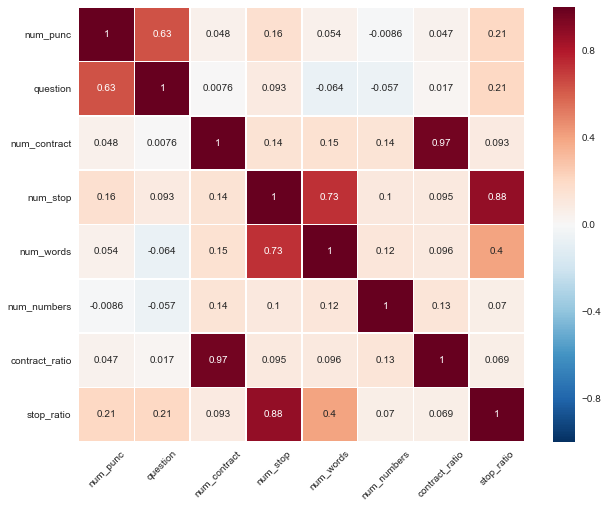

In [51]:
figure, axes = mp.subplots(figsize=(10,8))
sns.heatmap(df.drop(['text','clickbait'], axis=1).corr(), annot=True, vmax=1, linewidths=0.5)
mp.xticks(rotation=45)
mp.yticks(rotation=360)
mp.show()

There does appear to be some collinearity present, especially between contract_ratio vs. num_contract, and between stop_ratio vs. num_stop. This makes sense as the number of contractions or stopwords present will of course affect the contraction and stopword ratios. This collinearity could potentially jeopardize the accuracy of our classifier though, and to this end we can go ahead and drop num_stop and num_contract from our dataset.

In [52]:
df.drop(['num_stop','num_contract'], axis=1, inplace=True)

Now we can split our data into training and test sets and get to classifying! We'll put 80% of the data into the training set, and 20% into the test set.

In [92]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=0)

df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

To convert the headline text into the numerical data necessary for classification, we can use Scikit-Learn's TfidfVectorizer. The tf-idf is short for term frequency-inverse document frequency. In essence, tf-idf counts the number of occurrences of the words in each headline and weights these frequencies by their total number of occurrences across all headlines. The idea is that commonly occurring words like "the" and "can" appear so frequently that they are very likely to be unimportant in distinguishing between the two classes.

In [54]:
tfidf = TfidfVectorizer(min_df=3, max_features=None, strip_accents='unicode',
                           analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,5),
                           use_idf=1, smooth_idf=1, sublinear_tf=1)

X_train_text = tfidf.fit_transform(df_train['text'])
X_test_text  = tfidf.transform(df_test['text'])

Next, we can use CountVectorizer to count the number of part-of-speech occurrences in each headline. These counts are then scaled using StandardScaler.

In [55]:
cvec = CountVectorizer()

X_train_pos = cvec.fit_transform(df_train['part_speech'])
X_test_pos  = cvec.transform(df_test['part_speech'])

sc = StandardScaler(with_mean=False)
X_train_pos_sc = sc.fit_transform(X_train_pos)
X_test_pos_sc  = sc.transform(X_test_pos)

/Users/degravek/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


We can then isolate the engineered features and scale their values so that they heave a mean of zero and unit standard deviation. This is necessary for many classifiers in order to obtain good results.

In [58]:
X_train_val = df_train.drop(['clickbait','text','text_pro','part_speech'], axis=1).values
X_test_val  = df_test.drop(['clickbait','text','text_pro','part_speech'], axis=1).values

sc = StandardScaler()
X_train_val_sc = sc.fit(X_train_val).transform(X_train_val)
X_test_val_sc  = sc.transform(X_test_val)

y_train = df_train['clickbait'].values
y_test  = df_test['clickbait'].values

Lastly, we can combine the new tf-idf vectors with the scaled engineered features and store them as sparse arrays. This helps to save memory as the tf-idf vectors are extremely large, but are composed mostly of zeros.

In [59]:
from scipy import sparse

X_train = sparse.hstack([X_train_val_sc, X_train_text, X_train_pos_sc]).tocsr()
X_test  = sparse.hstack([X_test_val_sc, X_test_text, X_test_pos_sc]).tocsr()

It turns out that logistic regression tends to give the best results for this classification problem, so we'll use it here. Below, we can use GridSearchCV to find the best regularization parameter for the job.

In [ ]:
param_grid = [{'C': np.linspace(90,100,20)}]

grid_cv = GridSearchCV(LogisticRegression(), param_grid, scoring='accuracy', cv=10, verbose=1)
grid_cv.fit(X_train, y_train)

print(grid_cv.best_params_)
print(grid_cv.best_score_)

#Best parameter: 'C': 92.10526315789474
#Best accuracry:  0.906433372453

Ten-fold cross-validation suggests that we obtain a classification accuracy of about 90%. Not bad at all! We can now apply the classifier to our test data to make some final predictions.

In [ ]:
model = LogisticRegression(penalty='l2', C=92.10526315789474)
model = model.fit(X_train, y_train)
predict = model.predict(X_test)

print(classification_report(y_test, predict))

             precision    recall  f1-score   support

          0       0.91      0.93      0.92      1244
          1       0.91      0.90      0.91      1100

avg / total       0.91      0.91      0.91      2344

The classification report gives

* A precision value of 0.91
* A recall value of 0.91
* An F1-score of 0.91

Let's plot the confusion matrix.

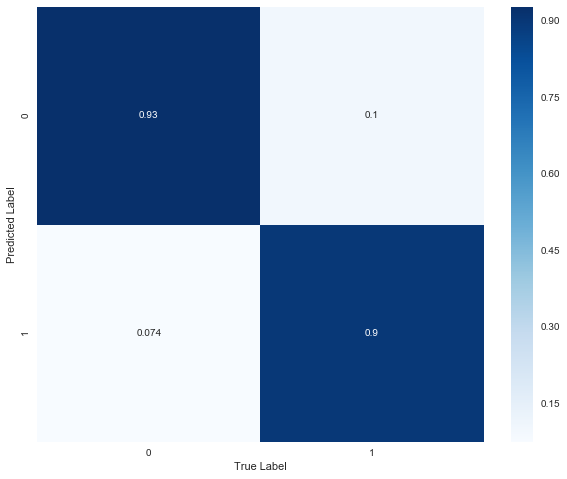

In [117]:
figure, axes = mp.subplots(figsize=(10,8))
cm = confusion_matrix(y_test, predict).T
cm = cm.astype('float')/cm.sum(axis=0)

sns.heatmap(cm, annot=True, cmap='Blues');
mp.xlabel('True Label')
mp.ylabel('Predicted Label')

The confusion matrix suggests that we misclassify real news headlines nearly as often as clickbait headlines (7.4% vs. 10% respectively). Now let's plot the corresponding ROC curve.

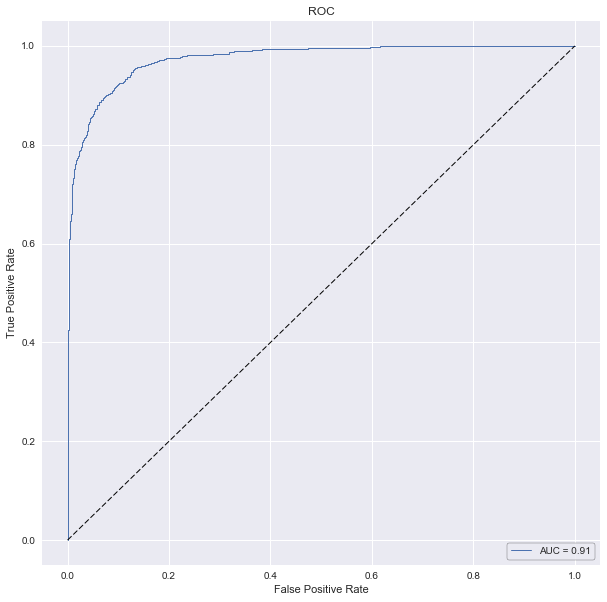

In [118]:
figure, axes = mp.subplots(figsize=(10,10))
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
roc_auc = roc_auc_score(y_test, predict)

mp.plot(fpr, tpr, lw=1, label='AUC = %0.2f'%(roc_auc))
mp.plot([0, 1], [0, 1], '--k', lw=1)
mp.xlabel('False Positive Rate')
mp.ylabel('True Positive Rate')
mp.title('ROC')
mp.legend(loc="lower right", frameon = True).get_frame().set_edgecolor('black')

As expected, the ROC curve is very good and hugs the upper left-hand corner of the figure. The area under the curve (AUC) is 0.91, suggesting good classification performance.

If we split the headlines into separate clickbait and non-clickbait groups, we can use tf-idf to compare which kinds of words occur more frequently among them.

In [87]:
tfidf_ycb = TfidfVectorizer(min_df=3, max_features=None, strip_accents='unicode',
                           analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,3),
                           use_idf=1, smooth_idf=1, sublinear_tf=1, stop_words='english')
ycb = tfidf_ycb.fit_transform(df_train.loc[df['clickbait']==1, 'text'])

tfidf_ncb = TfidfVectorizer(min_df=3, max_features=None, strip_accents='unicode',
                           analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,3),
                           use_idf=1, smooth_idf=1, sublinear_tf=1, stop_words='english')
ncb = tfidf_ncb.fit_transform(df_train.loc[df['clickbait']==0, 'text'])

ycb_values = ycb.mean(axis=0).tolist()
ycb_names = tfidf_ycb.get_feature_names()
ncb_values = ncb.mean(axis=0).tolist()
ncb_names = tfidf_ncb.get_feature_names()

We can place the results in two dataframes to handle them a little more easily.

In [88]:
import itertools

q_ycb = pd.DataFrame()
q_ycb['names'] = ycb_names
q_ycb['values'] = list(itertools.chain.from_iterable(ycb_values))
q_ycb = q_ycb.sort_values('values', ascending=True)

q_ncb = pd.DataFrame()
q_ncb['names'] = ncb_names
q_ncb['values'] = list(itertools.chain.from_iterable(ncb_values))
q_ncb = q_ncb.sort_values('values', ascending=True)

And plot the results.

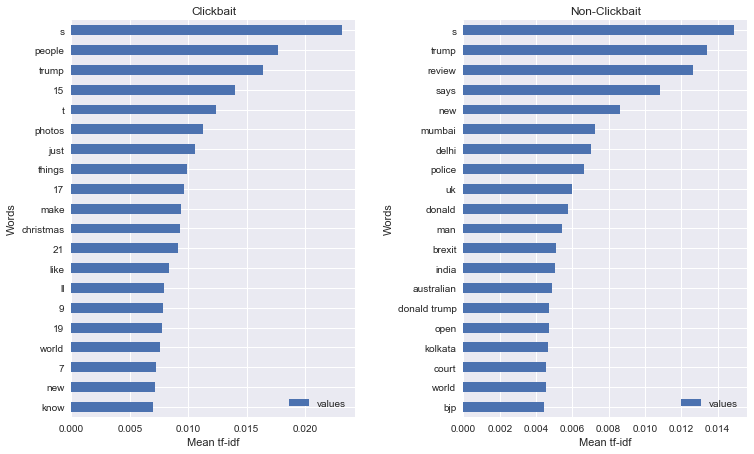

In [120]:
figure, axes = mp.subplots(nrows=1, ncols=2, figsize=(12,8))
mp.tight_layout(8,1)

plot = q_ycb[-20:].plot.barh(x='names', y='values', ax=axes[0], rot=0)
plot.set_xlabel('Mean tf-idf')
plot.set_ylabel('Words')
plot.set_title('Clickbait')

plot = q_ncb[-20:].plot.barh(x='names', y='values', ax=axes[1], rot=0)
plot.set_xlabel('Mean tf-idf')
plot.set_ylabel('Words')
plot.set_title('Non-Clickbait')

As we might expect, the words are quite different between the two sets. Clickbait headlines tend to contain words like "phots", "new", "things", etc., while the non-clickbait headlines contain more serious subject matter like "brexit", "australian", and "police". Also, note that several of the top clickbait features are numbers. These represent headlines like "10 things you'll never believe!".

Let's take a look at some of the headlines we misclassified.

In [111]:
df_test['predict'] = predict
print(df_test.loc[df_test['clickbait'] != df_test['predict'], ['text','clickbait','predict']][:10])

                                                 text  clickbait  predict
6    Kanye West Released From Hospital After One Week          1        0
12  Late-night hosts on the inauguration: 'How is ...          0        1
15  Zac Efron And His New Mustache Hold The Luckie...          1        0
22      A Look Back At Zsa Zsa Gabor's Nine Marriages          1        0
29  What lies beneath: discovering surprising jewe...          0        1
34  Telangana: Girl gangraped in front of boyfrien...          0        1
44  Auction For Ivanka Trump Coffee Date Canceled ...          1        0
46  John Brennan: Trump's 'Nazi Germany' tweet to ...          0        1
56  Washington Metro counted more trips for Womens...          1        0
60  The sad truth about having a baby: cattle care...          0        1


/Users/degravek/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [ ]:
                                                   text  clickbait  predict
6      Kanye West Released From Hospital After One Week          1        0
12    Late-night hosts on the inauguration: 'How is ...          0        1
86    The Future Of Starbucks Is Slower And More Exp...          1        0
90    Trump Says He Intends To Nominate Ben Carson A...          1        0
151   Moves like Middleton: the New York etiquette c...          0        1

There actually appear to be a few cases where a headline was deemed to be clickbait, though I personally might not have classified it as such. For example, the headlines "bruno mars might headline superbowl", and "night owls become early risers" were labeled as clickbait by the collectors of this dataset, though these could possibly constitute legitimate news headlines (albeit maybe poor ones).

# Concluding Remarks
In this notebook we used logistic regression and natural language processing to accurately classify clickbait headlines. The results were surprisingly good, as we obtained an accuracy score of 97.6%, an F1-score of 0.98, and an ROC AUC of 0.98. This classifier actually performs better than that of Chakraborty et al., in which an accuracy score of 93% was achieved. An interesting next step would be to use this classifier to deploy a real clickbait detection extension for a web browser like Firefox or Safari. This was actually done in the Chakraborty et al. paper, where an accuracy of 83% in blocking clickbaits was attained.

Well, that’s all I have for now. Thanks for following along!

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>